# Mapmaking

### Code from Sigurd Naess, adapted by Jeff McMahon


CMB telescopes observe by scanning across the sky and recording the response of each detector as a function of time as well as pointing information.  The detector response time series is commonly referred to as time-ordered data or a TOD.  Each CMB field is usually observed many times throughout one or more seasons yielding a large number of overlapping TODs.   At the pole, the sky rotation is aligned with the elevation axis of a telescope resulting in parallel scans in sky coordinates.  At midlatitude sites there is no such alignment and sky rotation can produce cross-linked scans.  Offline the TODs are processed to reconstruct the maps.   

In this notebook, you will (1) model TODs for a map that is observed horizontally and vertically to create a cross-linked set of TODs, (2) add 1/f noise to create TODs similar to what would be output from a CMB instrument, and (3) you will use several mapmaking codes to reconstruct maps from these time streams.   The mapmaking codes include (i) a simple binned average that works well if the TODs have negligible white noise (from the instrument (e.g., demodulated half-wave plate polarization data) or by prewhitening the data with a filter), and (ii) an iterative maximum likelihood mapmaker that accounts for the noise correlations from the atmosphere.

Exercises will guide you through the differences between cross-linked and non-crosslinked maps, and the impacts of filtering before and after mapmaking.


## First we read in the necessary libraries from previous code modules.

In [151]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pylab as pl 


#%cd /Users/eshaw/box/UTAustin_CMBSummerSchool/UT_Notebooks/
%matplotlib inline
import constants as cs # the constants module
from cmb_modules import * # the module of functions


N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = cs.atmospheric_noise_level
one_over_f_noise_level = cs.one_over_f_noise_level

C:\Users\eshaw\box\UTAustin_CMBSummerSchool\UT_Notebooks


## Recalculating the results from the previous stages

This creates a map with CMB, point sources, and SZ sources.  It also convolves the map with the beam.  Unlike previous map-based simulations, noise will be added in the time series which are calculated below.

Number of sources required:  5000
map mean: -55.653401004785685 map rms: 99.48967040895778


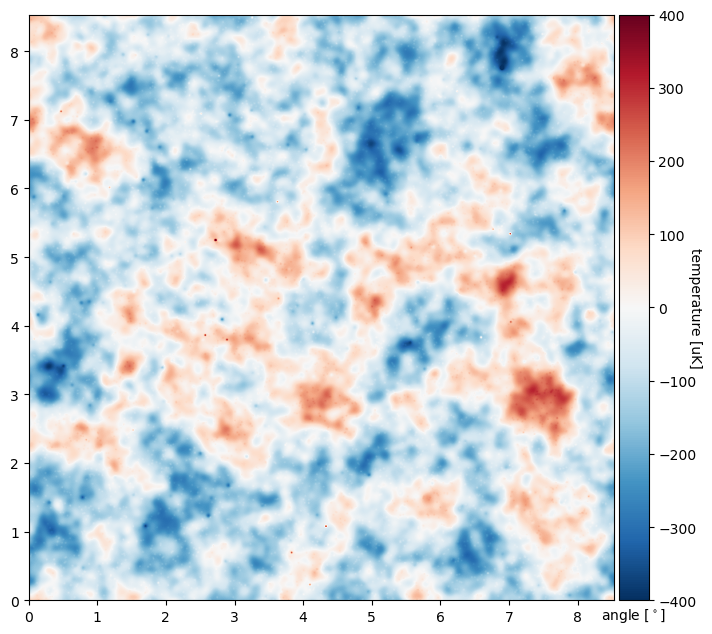

In [143]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,\
                                  Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap


## convolve with the beam
CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)

## plot the result
p=Plot_CMB_Map(CMB_T_convolved,c_min,c_max,X_width,Y_width, 8,8)

## save the result as "sky", a variable that represents the simulated sky we will map below
sky = total_map

In [9]:
sky.shape[-2]


1024

## Generating time streams from a simulated sky map

This is the first new piece of the notebook.  In this section we simulate the telescope scanning across the map.  For simplicity we consider two scan directions: left-right, and up-down. This code generates a list of pixels (x- and y coordinates) in the order in which they are observed.  



In [79]:
## a function to return the sequence of pixel indices as they are "observed" in these simualtions
def sim_pointing(map, dir=0):
    """Simulate a telescope scanning across the given map. The scanning pattern is
    as simple as possible: The samples hit the center of each pixel, and we
    scan rowwise (dir=0) or columnwise (dir=1).
    ** Updated to work if input map is not square. **
    """
    # The pointing is an [{y,x},nsamp] array of pixel positions
    # The einsum stuff is just to swap the second and third axis
    # of pixmap, which contains the pixel coordinates of each pixel.
    if dir == 0:                                          ## arranges these for L-R scans
        pixmap = np.mgrid[:map.shape[-2],:map.shape[-1]]  ## makes two arrays of the x and y indices in the map
        pixmap[1,1::2, :] = pixmap[1,1::2, ::-1]          ## reverse every other row so the scans go back and forth
        point = pixmap.reshape(2,-1)         
    else:
        pixmap = np.mgrid[:map.shape[-1],:map.shape[-2]]  ## arranges these for U-D scans
        pixmap[1,1::2, :] = pixmap[1,1::2, ::-1]
        point = np.roll(pixmap,1,axis=0).reshape(2,-1)   
    return point

In [11]:
"""
DEMONSTRATION:
What is that function doing?
The pointing is an [{y,x},nsamp] array of pixel positions
The sim_pointing function uses the numpy.mgrid instance, which returns an instance of a mesh grid.
You need to index it to have it return the dimensions you want, [and make sure you use square brackets]
"""
#Pretend our map is 6 pixels tall and 4 columns wide.
#Row Wise Scan
print('If you are doing a row-wise scan, make the first index the number of rows in your map')
testgrid = np.mgrid[:6, :4]
#print(testgrid)

print('Now we have to manipulate this to simulate scanning across map to observe all pixels.')
testgrid[1,1::2,:] = testgrid[1,1::2,::-1]
print(testgrid[1])
print('Now unwrap those to give the time-ordered y and x (row and col)')
print('y, row(t): ',testgrid.reshape(2,-1)[0])
print('x, col(t): ',testgrid.reshape(2,-1)[1])

print('\n For a Up-Down scan, make first index in mgrid the number of pixels wide the map is.')
testgrid = np.mgrid[:4, :6]
#print(testgrid)
testgrid[1,1::2,:] = testgrid[1,1::2,::-1]
print(testgrid[1])
print('Now unwrap those to give the time-ordered y and x (row and col) values')
print('y, row(t): ',np.roll(testgrid,1,axis=0).reshape(2,-1)[0]) 
print('x, col(t): ',np.roll(testgrid,1,axis=0).reshape(2,-1)[1])

If you are doing a row-wise scan, make the first index the number of rows in your map
Now we have to manipulate this to simulate scanning across map to observe all pixels.
[[0 1 2 3]
 [3 2 1 0]
 [0 1 2 3]
 [3 2 1 0]
 [0 1 2 3]
 [3 2 1 0]]
Now unwrap those to give the time-ordered y and x (row and col)
y, row(t):  [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5]
x, col(t):  [0 1 2 3 3 2 1 0 0 1 2 3 3 2 1 0 0 1 2 3 3 2 1 0]

 For a Up-Down scan, make first index in mgrid the number of pixels wide the map is.
[[0 1 2 3 4 5]
 [5 4 3 2 1 0]
 [0 1 2 3 4 5]
 [5 4 3 2 1 0]]
Now unwrap those to give the time-ordered y and x (row and col) values
y, row(t):  [0 1 2 3 4 5 5 4 3 2 1 0 0 1 2 3 4 5 5 4 3 2 1 0]
x, col(t):  [0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3]


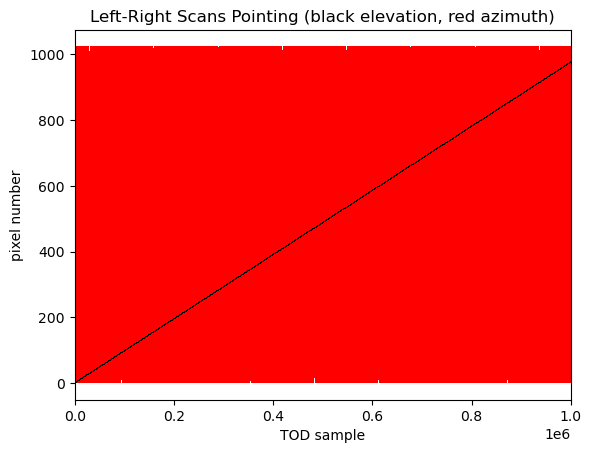

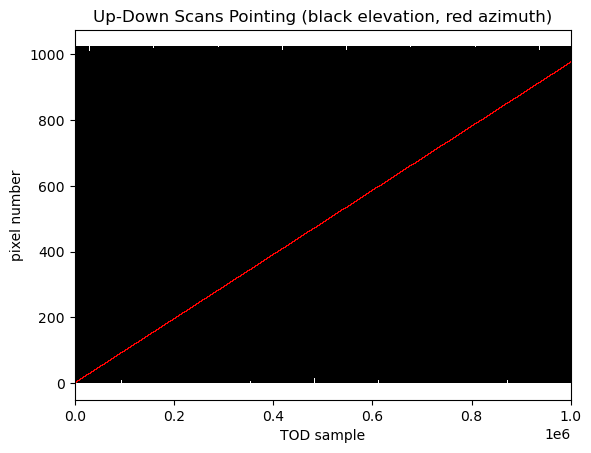

In [80]:
## generate left-right scans
point_lr = sim_pointing(sky, 0)

## generate Up-Down scans
point_ud = sim_pointing(sky, 1)

plt.plot(point_lr[1,:],"r,")
plt.plot(point_lr[0,:],"k,")
plt.title("Left-Right Scans Pointing (black elevation, red azimuth)")
plt.ylabel("pixel number")
plt.xlabel("TOD sample")
plt.xlim(0,1e6)
plt.show()

plt.plot(point_ud[0,:],"k,")
plt.plot(point_ud[1,:],"r,")
plt.title("Up-Down Scans Pointing (black elevation, red azimuth)")
plt.ylabel("pixel number")
plt.xlabel("TOD sample")
plt.xlim(0,1e6)
plt.show()

<font color='red'>EXERCISE 1: </font>  Make a zoomed-in plot of the scan strategies above by adjusting the x limit for the plot to be much smaller.     Discribe the scan strategy based on what you see in these plots.

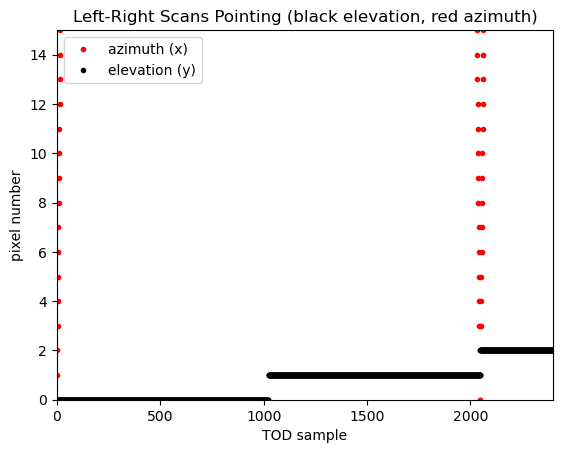

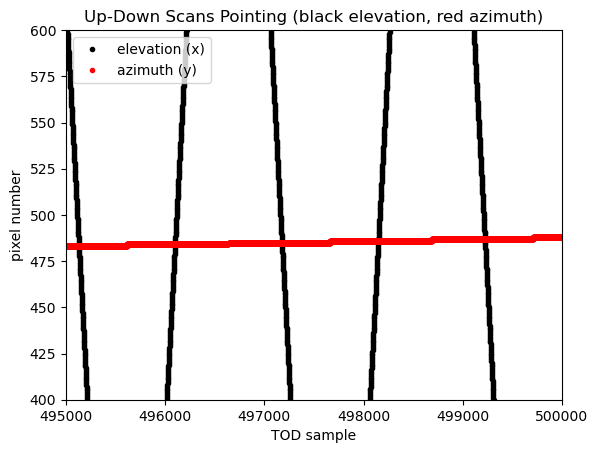

In [81]:
plt.plot(point_lr[1,:],"r.",label='azimuth (x)')
plt.plot(point_lr[0,:],"k.", label = 'elevation (y)')
plt.title("Left-Right Scans Pointing (black elevation, red azimuth)")
plt.ylabel("pixel number")
plt.xlabel("TOD sample")
plt.xlim(0,2400)
plt.ylim(0,15)
plt.legend(loc=2)
plt.show()

plt.plot(point_ud[0,:],"k.",label='elevation (x)')
plt.plot(point_ud[1,:],"r.", label = 'azimuth (y)')
plt.title("Up-Down Scans Pointing (black elevation, red azimuth)")
plt.ylabel("pixel number")
plt.xlabel("TOD sample")
plt.xlim(495e3,500e3)
plt.ylim(400,600)
plt.legend(loc=2)
plt.show()

[Your thoughts here]



In the first, the left-right scans, the elevation is constant and increments with each azimuth pass.
Full coverage in elevation takes a while for this style.
In the second, the up-down scan, the azimuth increments with each scan in elevation (up and down)
Full coverage in azimuth takes a while.

### Noiseless TODs

This code takes the pointing information generated above and makes a mock time-ordered-data (TOD) with no noise.

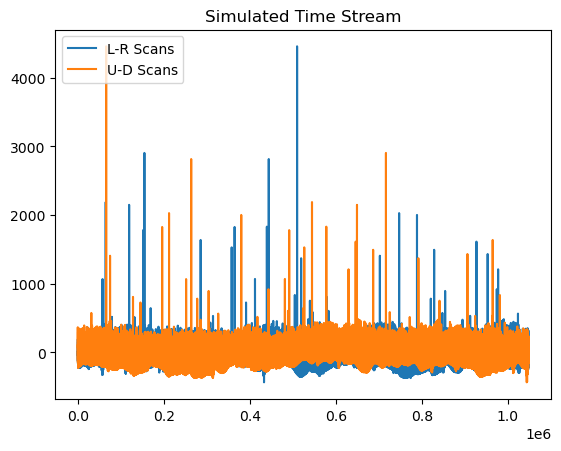

In [14]:
def Observe_map(map, point):
    """Pointing matrix: Project map to tod"""
    point = np.round(point).astype(int)
    return map[point[0],point[1]]  ## return the value of the map at each pointing, this forms the simulated time stream

noiseless_tod_lr = Observe_map(sky, point_lr)
noiseless_tod_ud = Observe_map(sky, point_ud)

plt.plot(noiseless_tod_lr, label = 'L-R Scans')
plt.plot(noiseless_tod_ud, label = 'U-D Scans')
plt.legend(loc=2)
plt.title('Simulated Time Stream')
plt.show()


<font color='red'>EXERCISE 2: </font>  Explain the spikes in the TOD and discuss whether the RMS of the TOD makes sense.

In [83]:
print('RMS of time ordered data LeftRight:', np.std(noiseless_tod_lr))
print('RMS of time ordered data UpDown:',np.std(noiseless_tod_ud))

RMS of time ordered data LeftRight: 95.37768346300747
RMS of time ordered data UpDown: 95.37768346300744


#### discussion goes here
Spikes are probably point sources in the map, but only in the +temperature direction. (colder spots though "bright" on map, don't have extra power hitting detectors)

RMS makes sense to me because most of map is within the pastel colors of map. +/- a few hundred

<font color='red'>OPTIONAL EXCERCISE: </font> Add in the impact of detector time constants to smear out these TODs.  This exercise is best done after completing the rest of the notebook so its impact can be propagated through this entire code to maps.  This will allow you to model the impact of this systematic effect.

NOTE: [this Wikipedia article](https://en.wikipedia.org/wiki/Exponential_smoothing) is useful in modeling exponential filters (e.g., detector time constants) This approach can be implemented with arrays using the np.roll function.

I found this article helpful: [https://dayanand-shah.medium.com/exponential-moving-average-and-implementation-with-python-1890d1b880e6], just replace "prices" in his example with the TOD data and play around with the weighting and period.

In [41]:
#s(t) = alpha*x(t) + (1-alpha)*s(t-1)

0.00624

In [160]:
def exponential_moving_average(tod, period, weighting_factor=0.2):
    """
    Inputs
        tod: array
        period: int, decides how many points at beginning of array to use to start off the filter at t=0
        weighting_factor (between 0 and 1)
            higher weighting factors decrease the smoothing. 
            lower weighting factors simulate a longer time constant.
    """
    #s(t) = alpha*x(t) + (1-alpha)*s(t-1)
    ema = np.zeros(len(tod))
    sma = np.mean(tod[:period])
    ema[period- 1] = sma
    for i in range(period, len(tod)):
        ema[i] = (tod[i] * weighting_factor) + (ema[i - 1] * (1 - weighting_factor))
    return ema

#play with your choices for period and weighting factor
tc_tod_lr = exponential_moving_average(noiseless_tod_lr,6, weighting_factor = .3)


(-100.0, 400.0)

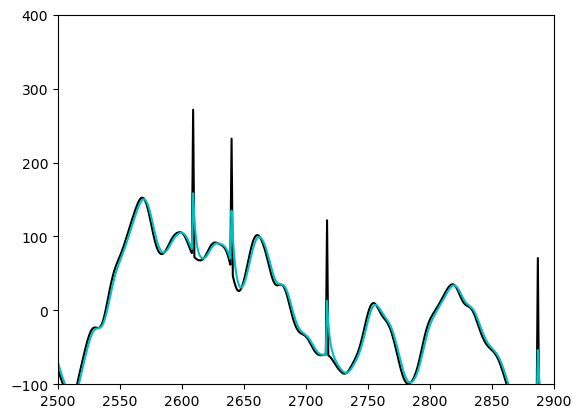

In [87]:
plt.figure()
plt.plot(noiseless_tod_lr,'k')
plt.plot(tc_tod_lr,'c')
plt.xlim(2500,2900)
plt.ylim(-100,400)

### Adding noise to the TOD

Here we build a noise power spectrum for the atmospheric and instrumental noise.   By default we assume the instrumental noise has an amplitude of 40 $\mu$-K per sample (1/2 arcmin pixels) which is similar to the full exposure of ACT-MBAC or SPT-SZ which were around 20 $\mu$ K- arcmin (SPT was slightly lower).   The atmospheric signal is modeled as a simple power law with a 0.1 s 1/f knee and a scan that spends $1/240$ s in each pixel which is equivelent to a $1^\circ/$s scan speed.   


( there are four half arc min pixels in 1 square arcmin)
$\frac{\frac{1}{240}\text{sec}}{1 \text{pixel}}* \frac{1 \text{pixel}}{0.5 \text{arcmin}}*\frac{60 \text{arcmin}}{1 \text{deg}} = 0.5 sec/deg *2$

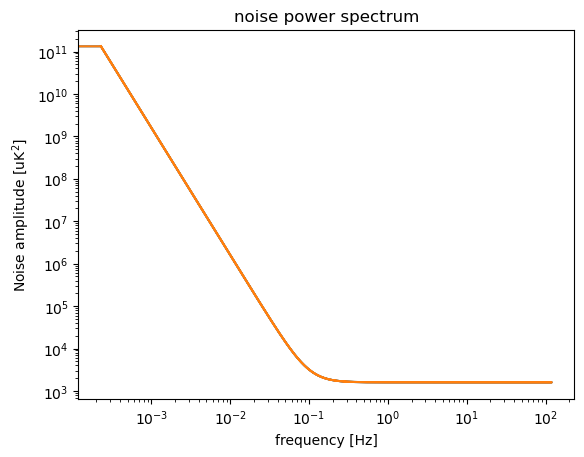

In [61]:
def sim_noise_spec(nsamp, dt=.00416, fknee=0.1, alpha=3, sigma=40):
    """Build a simple atmosphere + white noise model, and return it
    as a power spectrum."""
    freq   = np.abs(np.fft.fftfreq(nsamp, dt))
    return (1+(np.maximum(freq,freq[1])/fknee)**-alpha)*sigma**2

noise_spec_lr = sim_noise_spec(point_lr.shape[-1], dt=.00416, fknee=0.1, alpha=3, sigma=40)
noise_spec_ud = sim_noise_spec(point_ud.shape[-1], dt=.00416, fknee=0.1, alpha=3, sigma=40)
freq   = np.abs(np.fft.fftfreq(point_lr.shape[-1], .00416))

plt.loglog(freq,noise_spec_lr)
plt.loglog(freq,noise_spec_ud)
plt.title("noise power spectrum")
plt.xlabel("frequency [Hz]")
plt.ylabel("Noise amplitude [uK$^{2}$]")
#plt.ylim(1e3,1e5)
#plt.xlim(1e-2,10)
plt.show()


#### Investigate (not part of orig notebook)

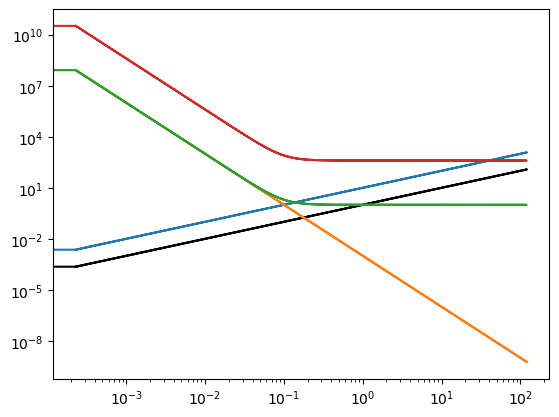

In [62]:
#BREAK IT DOWN INTO STEPS
dt=1/240.
nsamp=point_lr.shape[-1]
freq = np.abs(np.fft.fftfreq(nsamp,dt))

sigma=20
alpha=3
fknee=0.1

plt.figure()
plt.loglog(freq, np.maximum(freq,freq[1]),'k')
plt.loglog(freq, np.maximum(freq,freq[1])/fknee)
plt.loglog(freq, (np.maximum(freq,freq[1])/fknee)**-alpha)
plt.loglog(freq, (1+(np.maximum(freq,freq[1])/fknee)**-alpha))
plt.loglog(freq, (1+(np.maximum(freq,freq[1])/fknee)**-alpha)*sigma**2)



The next step is to generate a realization of this noise and add it to the noiseless time series.

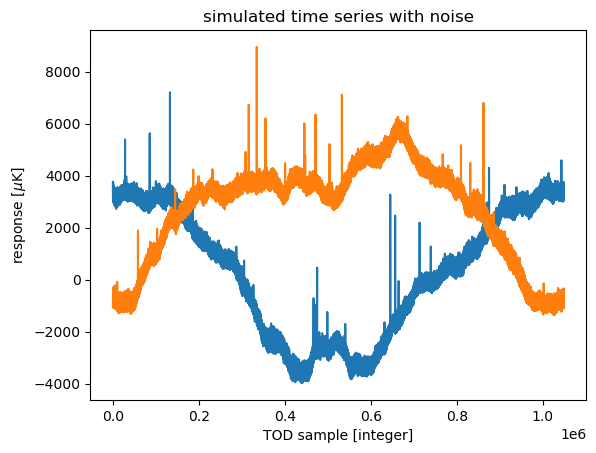

In [161]:
def sim_tod(map, point, noise_spec, return_noise_tod=False, add_detector_timeconstant=False,ema_period=6, ema_weight=0.3 ):
    """Simulate a noisy TOD using the model d = Pm + n"""
    tod    = Observe_map(map, point)
    #add step to add det time constant
    if add_detector_timeconstant:
        tod = exponential_moving_average(tod,ema_period, ema_weight)
    rand   = np.fft.fft(np.random.standard_normal(tod.shape[-1])) #generate gaussian random noise, essentially
    fnoise = rand * noise_spec**0.5
    tod   += np.fft.ifft(fnoise).real
    if return_noise_tod:
        return tod, np.fft.ifft(fnoise).real
    else:
        return tod


tod_lr, noise_lr = sim_tod(sky, point_lr, noise_spec_lr, True)
tod_ud, noise_ud = sim_tod(sky, point_ud, noise_spec_ud, True)

#plt.figure()
#plt.title('simulated noise time stream')
#plt.plot(noise_lr)
#plt.plot(noise_ud)
#plt.show()

plt.plot(tod_lr)
plt.plot(tod_ud)
plt.title("simulated time series with noise")
plt.ylabel("response [$\mu$K]")
plt.xlabel("TOD sample [integer]")
plt.show()

<font color='red'>EXERCISE 4: </font>  Typical detectors have noises of $\sim 300 \mu$K-$\sqrt{s}$.  Make a plot of what a time stream looks like with this instantaneous sensitivity so you can get a feel for what real data looks like.

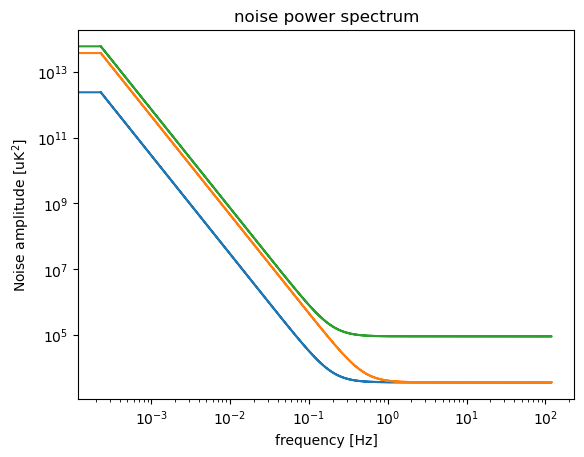

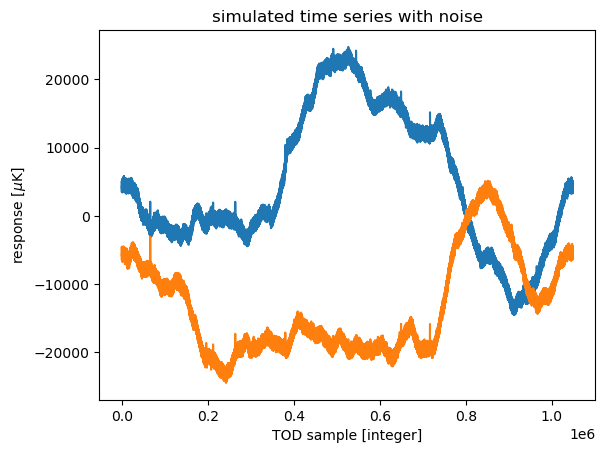

In [71]:
noise_spec_1 = sim_noise_spec(point_lr.shape[-1], dt=.00416, fknee=0.5, alpha=3, sigma=60)
noise_spec_2 = sim_noise_spec(point_lr.shape[-1], dt=.00416, fknee=0.2, alpha=3, sigma=300)

#noise_spec_ud = sim_noise_spec(point_ud.shape[-1], dt=.00416, fknee=0.2, alpha=3, sigma=60)
freq   = np.abs(np.fft.fftfreq(point_lr.shape[-1], .00416))

plt.loglog(freq,noise_spec_lr)
plt.loglog(freq,noise_spec_1)
plt.loglog(freq,noise_spec_2)
plt.title("noise power spectrum")
plt.xlabel("frequency [Hz]")
plt.ylabel("Noise amplitude [uK$^{2}$]")
#plt.ylim(1e3,1e5)
#plt.xlim(1e-2,10)
plt.show()

tod_lr = sim_tod(sky, point_lr, noise_spec_1)
tod_lr = sim_tod(sky, point_ud, noise_spec_2)

plt.figure()
plt.plot(tod_lr)
plt.plot(tod_ud)
plt.title("simulated time series with noise")
plt.ylabel("response [$\mu$K]")
plt.xlabel("TOD sample [integer]")
plt.show()

### Putting all the pieces together

For convenience, the following code bundles the TOD (signal and noise), with pointing information, and the noise spectrum into a class.   This object will be passed as input to the map making codes we develop below.

In [ ]:
def sim_dataset(map, num_data=2, dt=.00416, fknee=0.1, alpha=3, sigma=40, add_detector_timeconstant=False, ema_period = 6,ema_weight=0.3):
    """Simulate a dataset consisting of num_data scans across the sky.
    Returns a list of Data objects, each of which contains the tod,
    the pointing and the noise spectrum."""
    res = []
    for i in range(num_data):
        point = sim_pointing(map, i % 2) #I guess this just gives the lr and up down versions.
        noise_spec = sim_noise_spec(point.shape[-1], dt=dt, fknee=fknee, alpha=alpha, sigma=sigma)
        tod = sim_tod(map, point, noise_spec, False,add_detector_timeconstant,ema_period, ema_weight)
        res.append(Data(tod, point, noise_spec))
    return res


class Data:
    def __init__(self, tod, point, noise_spec):
        self.tod   = tod
        self.point = point
        self.noise_spec = noise_spec

print("Generating noisy TOD simulations")
tc_dataset = sim_dataset(sky, num_data = 10, dt=.00416, fknee=0.1, alpha=3, sigma=40,add_detector_timeconstant=True)
dataset  = sim_dataset(sky,num_data=10, dt=.00416, fknee=0.1, alpha=3, sigma=40)

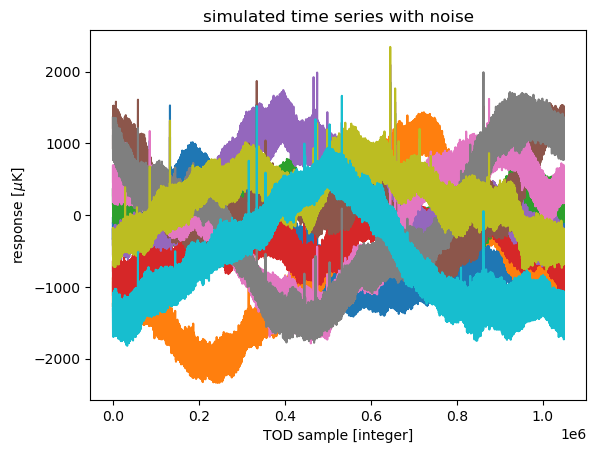

In [164]:
for data in tc_dataset:
    plt.plot(data.tod)
    
plt.title("simulated time series with noise")
plt.ylabel("response [$\mu$K]")
plt.xlabel("TOD sample [integer]")
plt.show()

# naieve mapmaking

Making maps from TODs is an inverse problem.  It can be epxressed in matrices as:
$$ P m = d.$$
Here $d$ is the TOD (whcih is a vector), $m$ is the sky map (whcih is also a vector), and $P$ is a (typically) rectangular matrix that specifies which pixel in the map was observed during each TOD sample.  (NOTE: many TOD sampeles usually correspond to the same pixel in our sky map.   

To solve for a map $m$ givein our TODs ($d$) we must invert this equaiton.   The standard technique is to use chi-squared minimizaiton.   Expressed in matrices this approach can be accomplished as derived here: 
$$ P m = d$$
$$ P^tP m  = P^t d      $$
$$ m = [P^tP]^{-1} P^t d.  $$

In other words, we can use the pointing matrix to construct a matrix $[P^tP]^{-1} P^t$ that acts on the TODs to return an estimate for the map.  The difficulty is implementing this when the number of smaples in the TODs are large, and in the presence of noise.

We have entirely ignored noise at this point.  (Noise correlations will be dealt with below.) 
However, in the limit where the noise is white the above equation can be solved with a simple binned average.  In this case one simply averages the TOD samples which observe a given pixel and returns a map comprized of these averages.  We implement this below and highlight the value and limitations of such code.  (The value is it is fast)

Solving for map while ignoring noise correlations
map mean: 121.92767795981948 map rms: 281.16764489935895


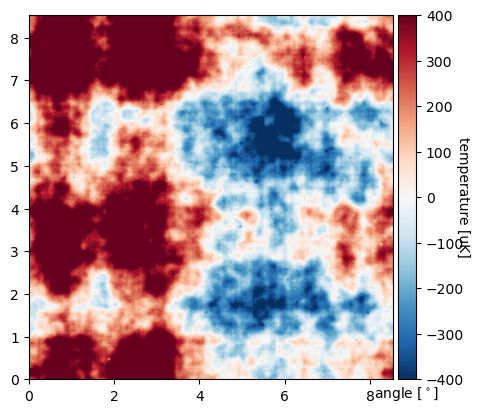

map mean: -43.35035957115194 map rms: 105.47684088364866


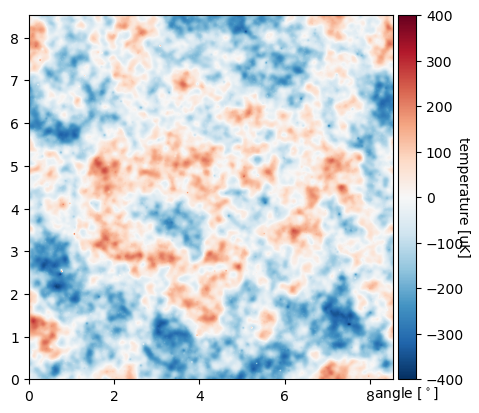

In [94]:
def solve_binned_average(dataset, shape):
    """Solve the simplified mapmaking equation Ax=b,
    where A = P'P and b = P'd, e.g. ignoring noise
    properties such as correlations."""
    rhs  = np.zeros(shape)
    hits = np.zeros(shape)
    for data in dataset:
        rhs  += PT(data.tod,    data.point, shape)
        hits += PT(data.tod*0+1, data.point, shape)
    return rhs/hits

def PT(tod, point, shape):
    """Transpose pointing matrix."""
    point = np.round(point).astype(int)
    point_flat = np.ravel_multi_index(point, shape[-2:])
    map = np.bincount(point_flat, tod, minlength=shape[-2]*shape[-1])
    map = map.reshape(shape[-2:])
    return map


print("Solving for map while ignoring noise correlations")
map_binned = solve_binned_average(dataset, sky.shape)
p=Plot_CMB_Map(map_binned,c_min,c_max,X_width,Y_width,5,5)
p=Plot_CMB_Map(CMB_T_convolved,c_min,c_max,X_width,Y_width, 5,5)
#p=Plot_CMB_Map(map_binned-sky,c_min,c_max,X_width,Y_width)  #for comparison 

<font color='red'>EXERCISE 5: </font>  Do you see comon structures in this map and the input sky map?

comment here

not really?

<font color='red'>EXERCISE 6: </font>  Remake the TOD and this map setting the 1/f knee to be absurly small.  Compare the new result to the originaly input map?

map mean: -39.0844161600211 map rms: 112.36392549685053


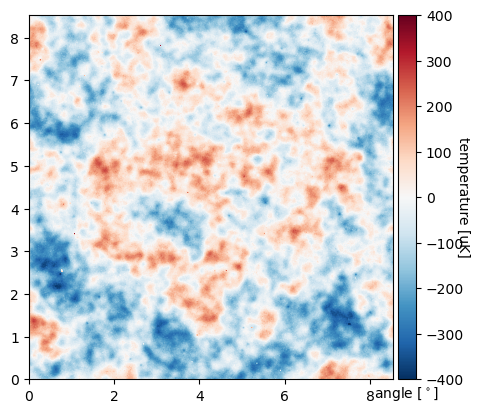

In [97]:
## code goes here
#made fknee  = 0.001 instead of 0.1
dataset  = sim_dataset(sky,num_data=2, dt=.00416, fknee=0.01, alpha=3, sigma=40)



map_binned = solve_binned_average(dataset, sky.shape)
p=Plot_CMB_Map(map_binned,c_min,c_max,X_width,Y_width,5,5)


Comment Here:

Without Low F Noise, this map looks much better.

<font color='red'>EXERCISE 7: </font>  reset the 1/f knee to its original value.  Now filter the time-series using a high-pass filter with a knee frequency set to whiten the TODs.   Remake the map and compare the new result to the input map.  What is different?

In [144]:
#Ok changing it back...
dataset  = sim_dataset(sky,num_data=2, dt=.00416, fknee=0.1, alpha=3, sigma=40)


In [107]:
from scipy import signal
def butterworth(tod,cutoff = 0.2):
    #cutoff = 0.2
    sos = signal.butter(2, cutoff, 'highpass', fs=240, output='sos')
    tod = signal.sosfilt(sos, tod)
    return tod


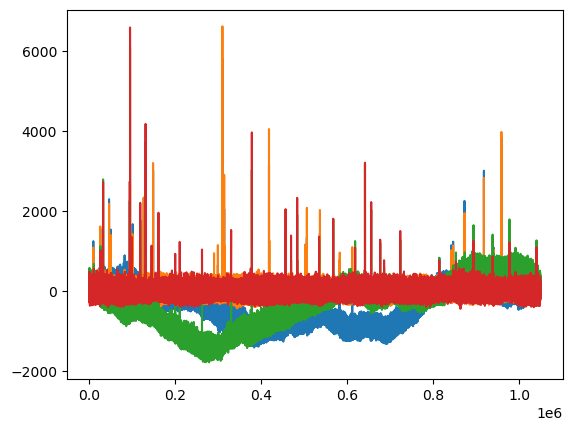

In [110]:
plt.figure()
for data in dataset:
    plt.plot(data.tod)
    plt.plot(butterworth(data.tod, cutoff = 0.2))

map mean: -0.005381523606818858 map rms: 91.50926748076125


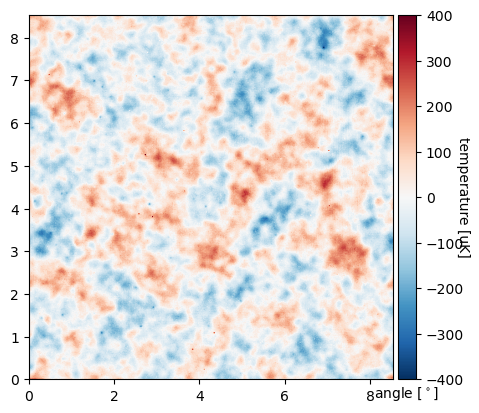

In [145]:
## code goes here
def solve_binned_average_highpass(dataset, shape,cutoff):
    """Solve the simplified mapmaking equation Ax=b,
    where A = P'P and b = P'd, e.g. ignoring noise
    properties such as correlations."""
    rhs  = np.zeros(shape)
    hits = np.zeros(shape)
    for data in dataset:
        rhs  += PT(butterworth(data.tod, cutoff=cutoff),    data.point, shape)
        hits += PT(butterworth(data.tod, cutoff=cutoff)*0+1, data.point, shape)
    return rhs/hits


map_binned = solve_binned_average_highpass(dataset, sky.shape,0.1)
p=Plot_CMB_Map(map_binned,c_min,c_max,X_width,Y_width,5,5)

# maximum likelihood mapmaking including noise correlations

Based on what we have seen above we need to develop a map-making approach that accounts for the noise correlations in our data.   To do this we implement a maximum liklihood mapmaking approach.  Expressed with matrices this is much like what we did above, except we include weighting by a matrix $N;^{-2}$ whose matrix elements are $1/\sigma^2_{ij}$ and encode the weight of each sample and correlations between samples in the TOD.   With this matrix our mapmaking approach can be derived as follows: 
$$ P m = d$$
$$ N^{-2} P m = N^{-2} d$$
$$ P^tN^{-2}P m  = P^tN^{-2} d      $$
$$ m = [P^tN^{-2}P]^{-1} P^tN^{-2} d.  $$

In summary, the matrix $[P^tN^{-2}P]^{-1} P^tN^{-2}$ can be applied to the TOD $d$ to produce the map $m$.

Given that the matrix $N^{-2}$ must have off-diagonal terms to encode noise correlations such as from $1/f$ noise, building this matrix is highly non-trival.  We thus resort to conjugate gradient technique [(see Wikipedia article)](https://en.wikipedia.org/wiki/Conjugate_gradient_method) to invert this equation with out ever explicitly building this materix.   These techniques are iteratative and thus we must run many iterations to arrive at an acceptable estimate for our map. 

We now run this for both a cross-linked and un-cross-linked maps.  Exercises follow.

In [ ]:
def solve_full(dataset, shape, niter=100, verbose=True):
    """Solve the full map-making equation
    Ax=b, where A = P'N"P and b = P'N"d."""
    # Set up our A matrix. We don't compute
    # explicitly because it's too big. Instead,
    # we define it as a function that can be applied
    # to a vector x. We will then use Conjugate Gradients
    # to invert it.
    def A(x):
        # x is 1d because the conjugate gradient solver works
        # on 1d arrays. So start by expanding it to 2d.
        x   = x.reshape(shape)
        res = x*0
        for data in dataset:
            tod  = Observe_map(x, data.point)
            tod  = mul_inv_noise(tod, data.noise_spec)
            res += PT(tod, data.point, shape)
        return res.reshape(-1)
    # Build our right-hand side b
    b = np.zeros(shape)
    for data in dataset:
        tod = mul_inv_noise(data.tod, data.noise_spec)
        b  += PT(tod, data.point, shape)
    # And solve
    cg = CG(A, b.reshape(-1))
    while cg.i < niter:
        cg.step()
        if verbose: print("iteration: %4d conjugate gradient error: %15.7e" % (cg.i, cg.err))
    return cg.x.reshape(shape)

def mul_inv_noise(tod, noise_spec):
    """Multiply by the inverse noise matrix. We assume that the noise
    is stationary, which means that it can be represented by a simple
    power spectrum noise_spec. This function is used to apply inverse
    variance weighting to the data."""
    ftod  = np.fft.fft(tod)
    ftod /= noise_spec
    return np.fft.ifft(ftod).real

def default_M(x):     return np.copy(x)
def default_dot(a,b): return a.dot(np.conj(b))
class CG:
    """A simple Preconditioned Conjugate gradients solver. Solves
    the equation system Ax=b."""
    def __init__(self, A, b, x0=None, M=default_M, dot=default_dot):
        """Initialize a solver for the system Ax=b, with a starting guess of x0 (0
        if not provided). Vectors b and x0 must provide addition and multiplication,
        as well as the .copy() method, such as provided by numpy arrays. The
        preconditioner is given by M. A and M must be functors acting on vectors
        and returning vectors. The dot product may be manually specified using the
        dot argument. This is useful for MPI-parallelization, for example."""
        # Init parameters
        self.A   = A
        self.b   = b
        self.M   = M
        self.dot = dot
        if x0 is None:
            self.x = b*0
            self.r = b
        else:
            self.x   = x0.copy()
            self.r   = b-self.A(self.x)
        # Internal work variables
        n = b.size
        self.z   = self.M(self.r)
        self.rz  = self.dot(self.r, self.z)
        self.rz0 = float(self.rz)
        self.p   = self.z
        self.err = np.inf
        self.d   = 4
        self.arz = []
        self.i   = 0
    def step(self):
        """Take a single step in the iteration. Results in .x, .i
        and .err being updated. To solve the system, call step() in
        a loop until you are satisfied with the accuracy. The result
        can then be read off from .x."""
        Ap = self.A(self.p)
        alpha = self.rz/self.dot(self.p, Ap)
        self.x += alpha*self.p
        self.r -= alpha*Ap
        self.z = self.M(self.r)
        next_rz = self.dot(self.r, self.z)
        self.err = next_rz/self.rz0
        beta = next_rz/self.rz
        self.rz = next_rz
        self.p = self.z + beta*self.p
        self.arz.append(self.rz*alpha)
        self.i += 1

In [165]:
print("Solving for map while taking noise correlations into account")


## For data set with detector time constants added in:
#gives some smearing in x and y, like a twinkle star on the point sources.

map_full  = solve_full(tc_dataset, sky.shape,niter=50)

Solving for map while taking noise correlations into account
iteration:    1 conjugate gradient error:   1.9967427e-02
iteration:    2 conjugate gradient error:   1.3897506e-03
iteration:    3 conjugate gradient error:   4.1104407e-05
iteration:    4 conjugate gradient error:   9.3357151e-06
iteration:    5 conjugate gradient error:   6.2323072e-07
iteration:    6 conjugate gradient error:   1.4878744e-08
iteration:    7 conjugate gradient error:   1.2789155e-09
iteration:    8 conjugate gradient error:   1.9037213e-11
iteration:    9 conjugate gradient error:   1.9133908e-13
iteration:   10 conjugate gradient error:   1.0759231e-14
iteration:   11 conjugate gradient error:   6.9597131e-16
iteration:   12 conjugate gradient error:   1.3310086e-15
iteration:   13 conjugate gradient error:   3.7645626e-14
iteration:   14 conjugate gradient error:   1.3445686e-12
iteration:   15 conjugate gradient error:   4.9025192e-11
iteration:   16 conjugate gradient error:   2.1207591e-09
iteration: 

map mean: 1.249000902703301e-13 map rms: 99.56145429680724


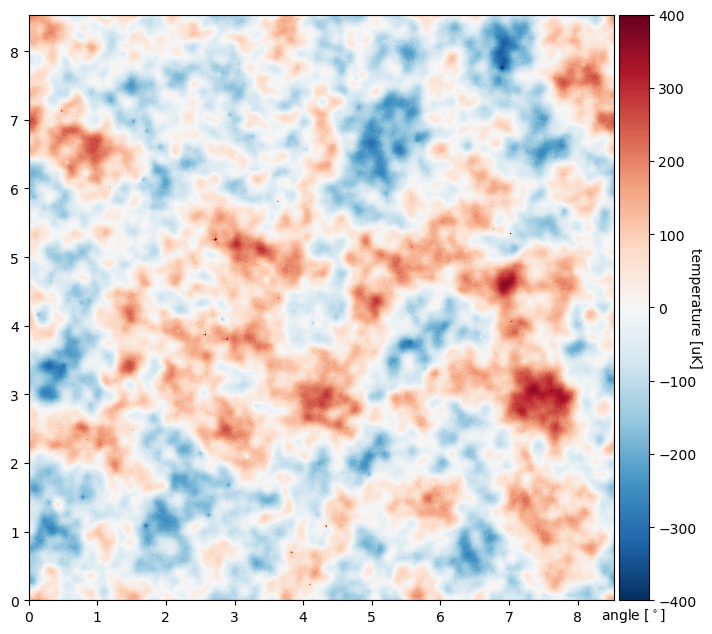

In [166]:
p=Plot_CMB_Map(map_full - np.mean(map_full),c_min,c_max,X_width,Y_width,8,8)

map mean: 1.0019762797242038e-14 map rms: 107.51710265534606


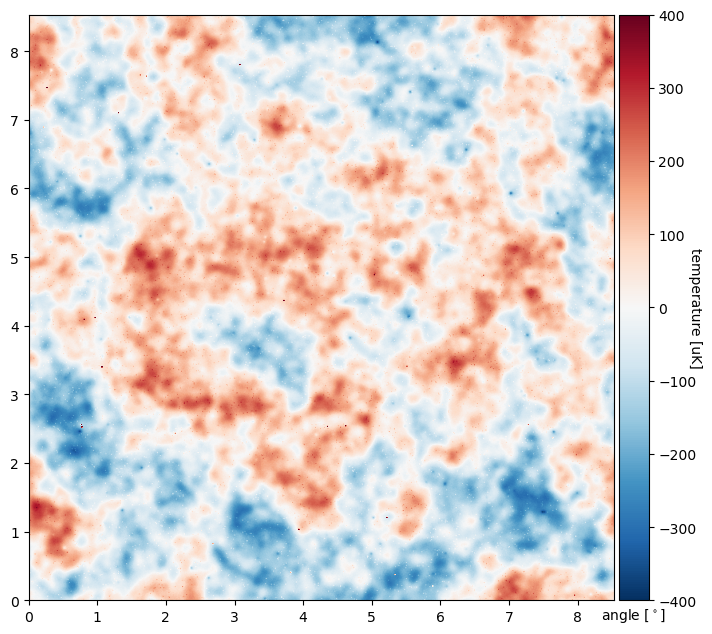

In [139]:
p=Plot_CMB_Map(map_full - np.mean(map_full),c_min,c_max,X_width,Y_width,8,8)

### maps with out cross linking

In [121]:
print("Solving for map while taking noise correlations into account")
map_single = solve_full(dataset[0:1], sky.shape,niter=50)

Solving for map while taking noise correlations into account
iteration:    1 conjugate gradient error:   2.7933241e-03
iteration:    2 conjugate gradient error:   1.0967050e-04
iteration:    3 conjugate gradient error:   2.7813991e-06
iteration:    4 conjugate gradient error:   2.5177625e-06
iteration:    5 conjugate gradient error:   1.4841739e-06
iteration:    6 conjugate gradient error:   9.8149155e-07
iteration:    7 conjugate gradient error:   5.9558940e-07
iteration:    8 conjugate gradient error:   5.8649868e-07
iteration:    9 conjugate gradient error:   4.6026216e-07
iteration:   10 conjugate gradient error:   3.8579899e-07
iteration:   11 conjugate gradient error:   3.7123174e-07
iteration:   12 conjugate gradient error:   2.7649269e-07
iteration:   13 conjugate gradient error:   2.5942548e-07
iteration:   14 conjugate gradient error:   2.3496788e-07
iteration:   15 conjugate gradient error:   2.0390822e-07
iteration:   16 conjugate gradient error:   1.8044001e-07
iteration: 

map mean: 2.0261570199409107e-15 map rms: 107.1688923439451


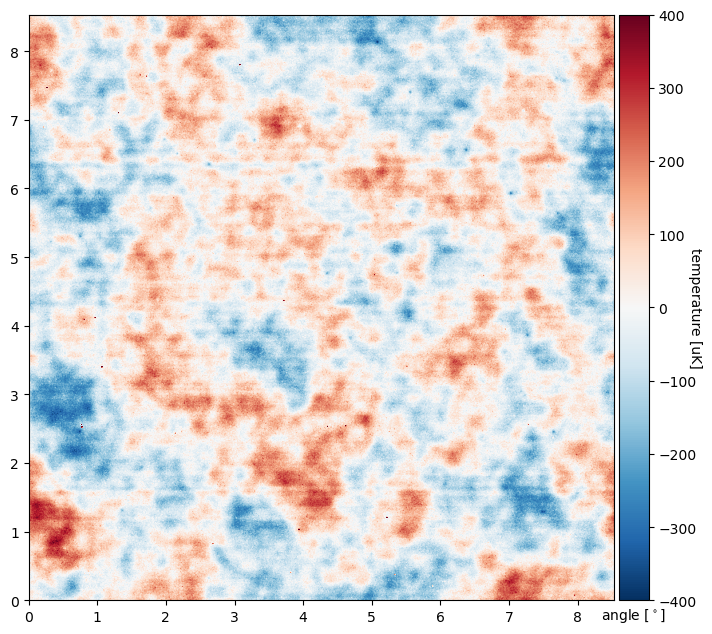

In [141]:
p=Plot_CMB_Map(map_single - np.mean(map_single),c_min,c_max,X_width,Y_width,8,8)

<font color='red'>EXERCISE 8: </font>  Compare the cross-linked and non-crosslinked maps.  The horizontal strips in the non-crosslinked maps are refered to (uncreatively) as stripes.

map mean: 340.6074109627943 map rms: 52.03115422935518


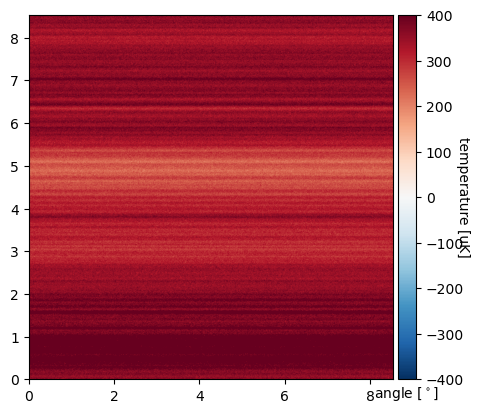

In [123]:
p=Plot_CMB_Map(map_single - map_full,c_min,c_max,X_width,Y_width,5,5)

<font color='red'>EXERCISE 9: </font>  Make plots of these maps in 2-d fourier space

 Compare these 2d fourier plots here. Be sure to note where modes are missing or de-weighted in each map. 

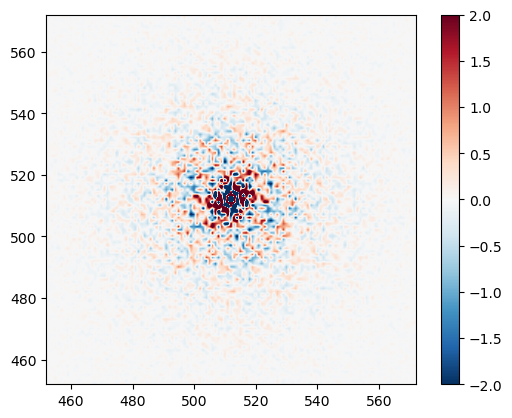

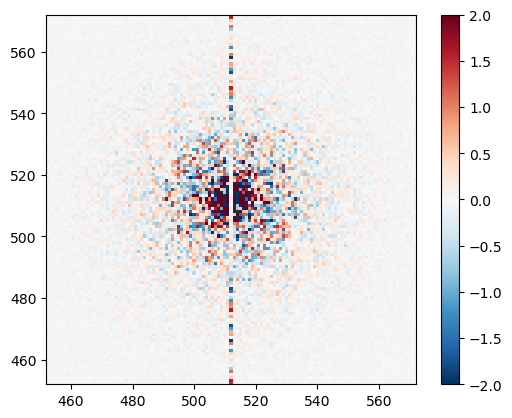

In [126]:
zoommin, zoommax = 512 - 60, 512+60
vmin = -2
vmax= 2

FMap_full = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(map_full)))

plt.figure()
im = pl.imshow(np.real(FMap_full), interpolation='bilinear', origin='lower',cmap="RdBu_r",vmin=vmin, vmax=vmax)
plt.xlim(zoommin, zoommax)
plt.ylim(zoommin, zoommax)
plt.colorbar()
plt.show()

FMap_single = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(map_single)))
plt.figure()
#fft_single= np.fft.fft2(map_single)
im = pl.imshow(np.real(FMap_single), interpolation='none', origin='lower',cmap="RdBu_r",vmin=vmin, vmax=vmax)
plt.xlim(zoommin, zoommax)
plt.ylim(zoommin, zoommax)
plt.colorbar()

<font color='red'>EXERCISE 10: </font>  Filter the non-crosslinked map to remove the stripes.  The can be accomplised by masking the relevent modes in your 2d fourier plot before inverse fouerier transforming to create the map.

comment on the difference between the filter map non-crosslinked map, the crosslinked map, and the input map.   Make difference plots if that seems useful.

In [157]:
def Filter_Map_MultiMask(Map, N, N_Xdestripe=0, N_Ydestripe=0, N_R_mask_min=0, N_R_mask_max=None, return_mask=False):
    """
    Filters a map by masking in fourier space. 
    Choose N_Xdestripe for destriping in X direction
    Choose N_Ydestripe for destriping in Y direction
    Choose N_R_mask* for general ell masking. 
        _min all 'ells' smaller than min are masked
        _max all 'ells' larger than max are masked
    """
    N=int(N) #this is the number of pixels in the map.
    
    ## set up a x, y, and r coordinates for mask generation
    ones = np.ones(N)
    inds = (np.arange(N)+.5 - N/2.)
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.) ## angles relative to 1 degrees

    ## make a mask
    mask = np.ones([N,N])
    mask[np.where(np.abs(X) < N_Xdestripe)] = 0 
    mask[np.where(np.abs(Y) < N_Ydestripe)] = 0    
    mask[np.where(R < N_R_mask_min )] = 0
    if N_R_mask_max is not None:
        if N_R_mask_max < N_R_mask_min:
            print('Invalid max ell, choose max radius to be bigger than minimum')
        else:
            mask[np.where(R > N_R_mask_max)] = 0         
    
    ## apply the filter in fourier space
    FMap = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(Map)))
    FMap_filtered = FMap * mask
    Map_filtered = np.real(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(FMap_filtered))))

    if return_mask:
        return Map_filtered, mask
    else:
        return Map_filtered

def Plot_Mask_FMap(map, mask):
    # Input unfiltered map and the mask.
    #STEP BY STEP PLOTS
    plt.figure(figsize=(6,6))
    plt.title('Mask')
    plt.imshow(mask, interpolation='bilinear', origin='lower',cmap='seismic')
    #plt.xlim(N/2 - 50, N/2+50)
    #plt.ylim(N/2 - 50, N/2+50)
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(6,6))
    plt.title('Fourier map')
    FMap = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(map)))
    plt.imshow(np.real(FMap),interpolation='bilinear',cmap='seismic',vmin=-3, vmax=3)
    #plt.xlim(N/2 - 50, N/2+50)
    #plt.ylim(N/2 - 50, N/2+50)
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(6,6))
    plt.imshow(np.real(FMap*mask),cmap='seismic',vmin=-3, vmax=3)
    plt.xlim(N/2 - 50, N/2+50)
    plt.ylim(N/2 - 50, N/2+50)
    plt.title('Fourier Map * mask')
    plt.colorbar()
    plt.show()
    FMap_filtered = FMap * mask
    filtered_map = np.real(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(FMap_filtered))))    
    plt.figure()
    plt.title('My Filtered Map')
    p=Plot_CMB_Map(filtered_map,c_min,c_max,N, N,figsize_x=6,figsize_y=6)


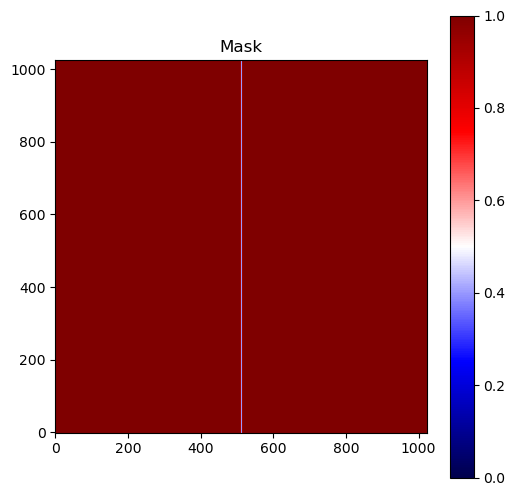

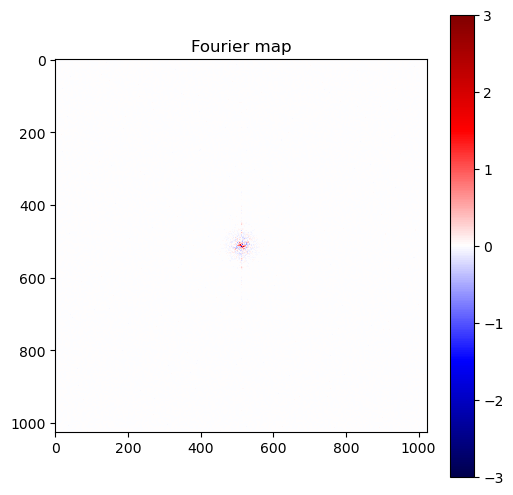

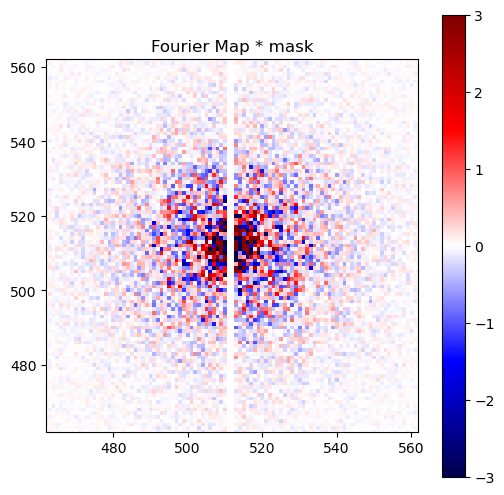

map mean: 1.4849232954361469e-15 map rms: 98.8903121797967


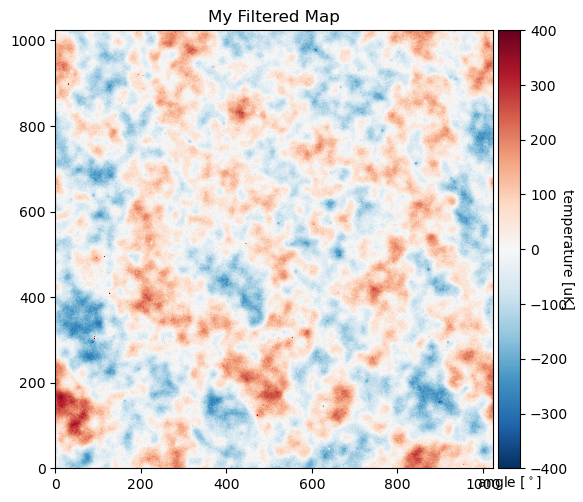

In [158]:
Map_Filtered, mask = Filter_Map_MultiMask(map_single, N, 1,0,0,None,return_mask=True)
Plot_Mask_FMap(map_single, mask)


map mean: -1.493805079633148e-13 map rms: 110.92005600680683


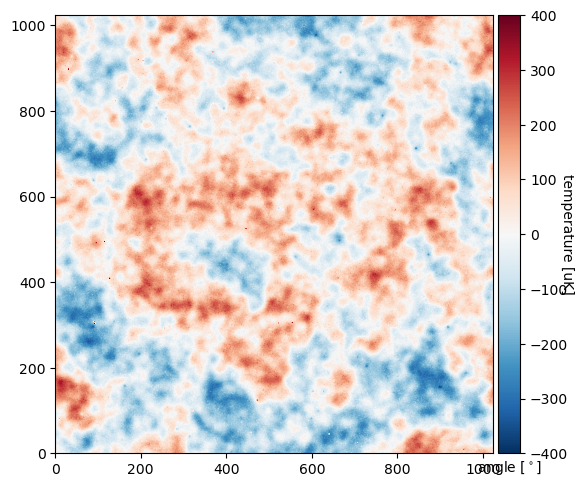

map mean: 1.4849232954361469e-15 map rms: 98.8903121797967


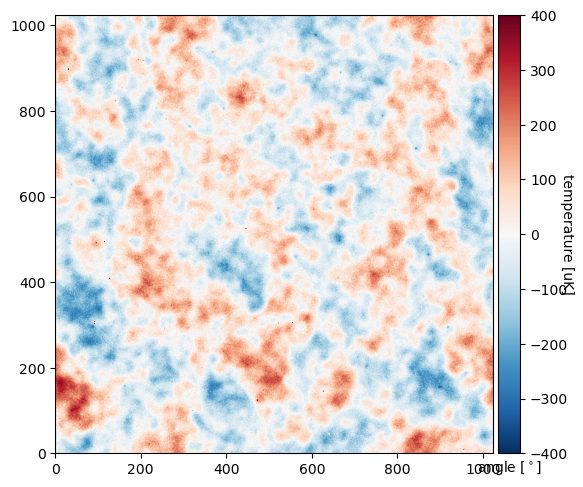

map mean: -0.008487557416246093 map rms: 107.1688923439451


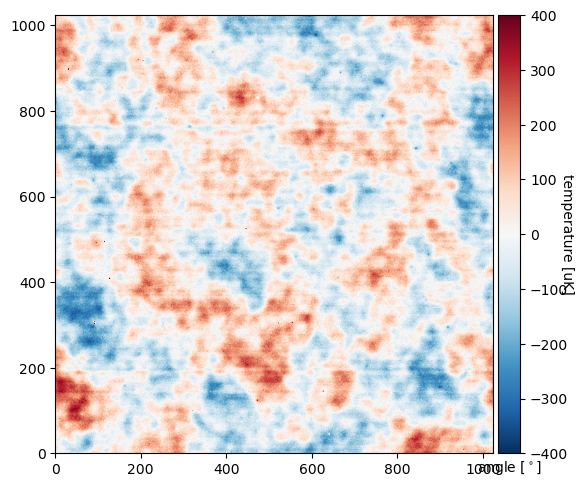

In [131]:
Map_filtered1 = Filter_Map(map_single, N, 1, 0, 0, None)

p=Plot_CMB_Map(map_full - np.mean(map_full),c_min,c_max,N, N,figsize_x=6,figsize_y=6)
p=Plot_CMB_Map(Map_filtered1,c_min,c_max,N, N,figsize_x=6,figsize_y=6)
p=Plot_CMB_Map(map_single,c_min,c_max,N, N,figsize_x=6,figsize_y=6)

What happens when you change the destriping to be large? or very small?

map mean: 0.0 map rms: 56.27088402368644


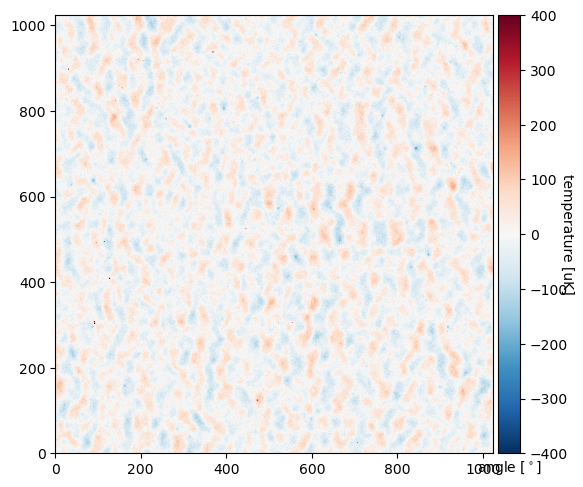

In [159]:
Map_filtered1 = Filter_Map(map_single, N, 10, 0, 0, None)
p=Plot_CMB_Map(Map_filtered1,c_min,c_max,N, N,figsize_x=6,figsize_y=6)